In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('attribution_data.csv')

In [7]:
df.shape

(586737, 6)

In [8]:
df.head(3)

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display


In [9]:
conversion_rate = round(df.groupby('cookie')['conversion'].sum().sum() / df['cookie'].nunique() * 100, 3)
print(f'Rate of user who is conversioned = {conversion_rate}%')

Rate of user who is conversioned = 7.346%


In [10]:
pivot_df = pd.pivot_table(data=df, index='cookie', columns='channel', values='conversion')

In [11]:
pivot_df.head()

channel,Facebook,Instagram,Online Display,Online Video,Paid Search
cookie,,,,,
00000FkCnDfDDf0iC97iC703B,NaN,0.0,0.0,NaN,NaN
0000nACkD9nFkBBDECD3ki00E,NaN,NaN,NaN,NaN,0.0
0003EfE37E93D0BC03iBhBBhF,NaN,NaN,NaN,NaN,0.0
00073CFE3FoFCn70fBhB3kfon,NaN,0.0,NaN,NaN,NaN
00079hhBkDF3k3kDkiFi9EFAD,NaN,NaN,NaN,NaN,0.0


In [12]:
data = pd.DataFrame(np.where(pivot_df.isnull(), 0, 1), columns=pivot_df.columns.values)

label = df.groupby('cookie')['conversion'].sum()
data['conversion'] = pivot_df.join(label, how='left')['conversion'].values

In [36]:
print(f'{data.shape}')
data.head(3)

(240108, 6)


,Facebook,Instagram,Online Display,Online Video,Paid Search,conversion
0,0,1,1,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0


In [15]:
data['conversion'].value_counts()

0    222469
1     17639
Name: conversion, dtype: int64

## Bagged Logistic Regression

In [37]:
X, y = data.drop('conversion', axis=1), data['conversion']
iteration = 100
val_avg_acc = 0.0
avg_coef = np.zeros(len(X.columns))

for _ in tqdm(range(iteration)):
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.5, shuffle=True, stratify=y)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    val_avg_acc += accuracy_score(y_val, y_pred) / iteration
    avg_coef += model.coef_.reshape(-1) / iteration

print(f'Avg accuracy = {val_avg_acc:.3f}')
print(f'Avg coef = {avg_coef}')
    

100%|██████████| 100/100 [00:17<00:00,  5.58it/s]

Avg accuracy = 0.927
Avg coef = [0.30472068 0.37223955 0.14791499 0.56154922 0.14674653]


## coef viz

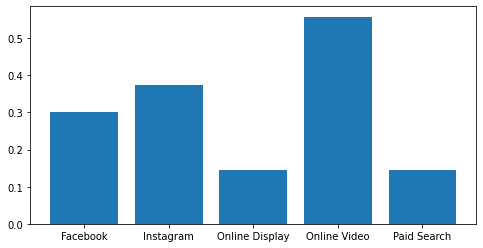

In [34]:
plt.figure(figsize=(8,4))
x = [0,1,2,3,4]
plt.bar(x, avg_coef)
plt.xticks(x, list(X.columns.values))
plt.show()